## Load libraries

In [107]:
# load libraries
import os
import numpy as np
import pandas as pd

import seaborn as sns
import random
import pmdarima as pm

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#sklearn modules
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

#Time Series
import datetime
from datetime import datetime
from datetime import timedelta
from time import time
from pandas.tseries.offsets import DateOffset

#Statsmodels
import statsmodels

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Load data set

In [50]:
os.chdir('C://Users//Jax//Desktop//DAC//Project')
os.getcwd()

'C:\\Users\\Jax\\Desktop\\DAC\\Project'

In [51]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ')

In [52]:
data = pd.read_csv("yieldsamurai_data_uniswapv2_USDCWETH.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [53]:
data['DAPR'] = data['DAPR'].str.rstrip('%').astype('float')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 2020-05-05 to 2022-04-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAPR    715 non-null    float64
 1   TVL     715 non-null    object 
dtypes: float64(1), object(1)
memory usage: 16.8+ KB


In [55]:
data.head()

,DAPR,TVL
Date,,
2020-05-05,4.47,1.78
2020-05-06,0.10,1.98
2020-05-07,0.00,2
2020-05-08,0.00,3.06
2020-05-09,0.00,13.09


In [56]:
df = data.asfreq(pd.infer_freq(data.index))

In [57]:
DAPR_series = df.DAPR

In [58]:
DAPR_series

Date
2020-05-05     4.47
2020-05-06     0.10
2020-05-07     0.00
2020-05-08     0.00
2020-05-09     0.00
              ...  
2022-04-15     4.93
2022-04-16     3.19
2022-04-17    14.14
2022-04-18    14.33
2022-04-19    12.05
Freq: D, Name: DAPR, Length: 715, dtype: float64

## Pre-processing

In [59]:
# Get the Peaks and Troughs
doublediff = np.diff(np.sign(np.diff(df.DAPR)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*df.DAPR)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

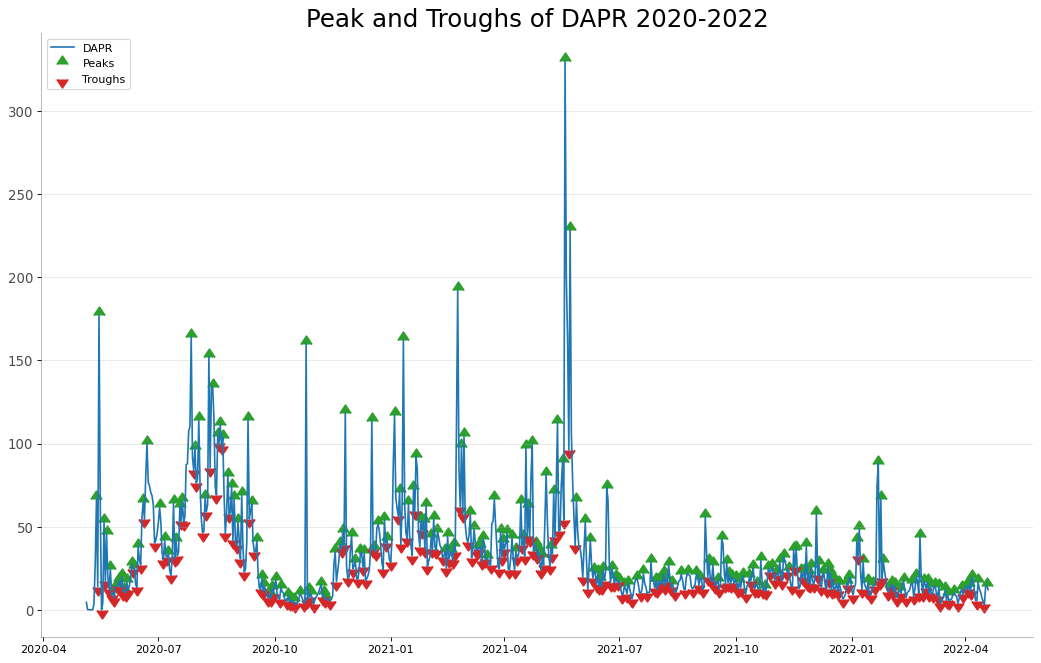

In [60]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(df.DAPR.index, 'DAPR', data=df, color='tab:blue', label='DAPR')
plt.scatter(df.index[peak_locations], df.DAPR[peak_locations], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Peaks')
plt.scatter(df.index[trough_locations], df.DAPR[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Troughs')

# Decoration
plt.title("Peak and Troughs of DAPR 2020-2022", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

In [61]:
def plot_series(series):
    plt.figure(figsize=(16,10), dpi=80)
    plt.plot(DAPR_series, color='red')
    plt.ylabel('DAPR %', fontsize=16)

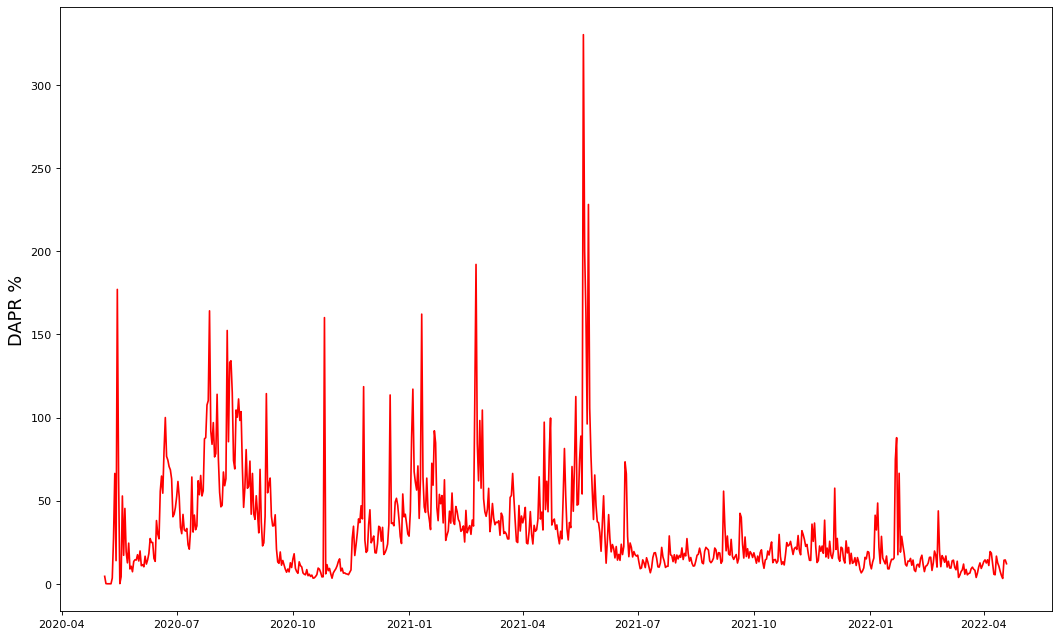

In [62]:
plot_series(DAPR_series)

## Normalise data

In [63]:
avg, dev = DAPR_series.mean(), DAPR_series.std()

In [64]:
DAPR_series = (DAPR_series - avg) / dev

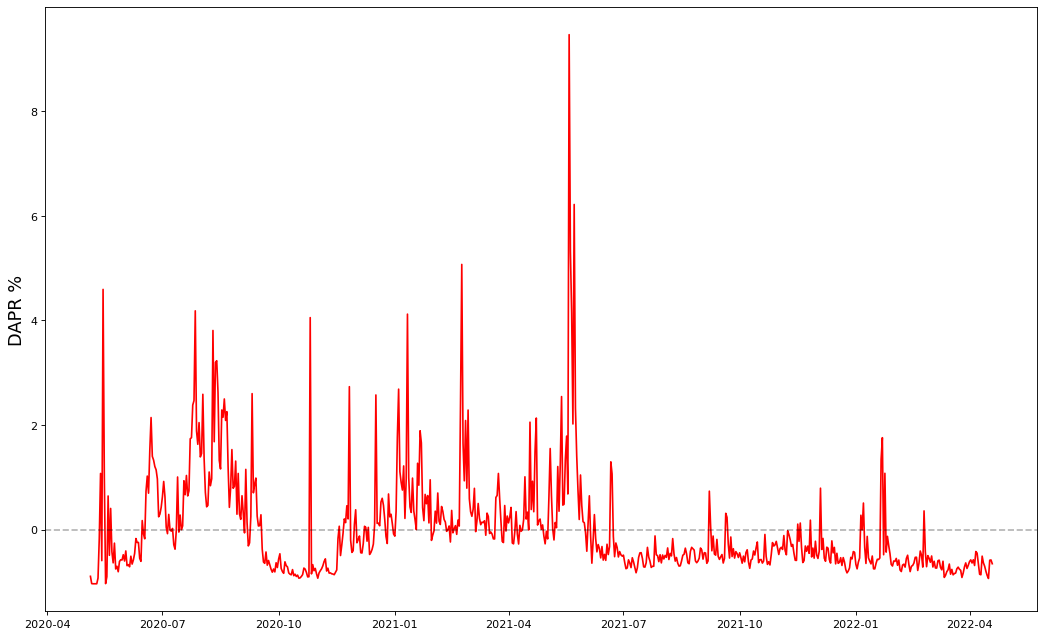

In [65]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Remove Increasing Volatility (Daily)

In [66]:
daily_volatility = DAPR_series.groupby(DAPR_series.index.day).std()

In [67]:
daily_volatility

Date
1     0.551696
2     0.756431
3     0.706196
4     0.860337
5     0.621957
6     0.453823
7     0.557908
8     0.553044
9     0.476764
10    1.130268
11    1.062819
12    0.906064
13    1.064686
14    0.761440
15    1.145899
16    0.646189
17    0.950044
18    0.833367
19    2.112569
20    1.341097
21    1.202945
22    1.080115
23    1.835068
24    0.928523
25    0.914154
26    1.304715
27    1.081470
28    0.851463
29    0.635488
30    0.672304
31    0.574417
Name: DAPR, dtype: float64

In [68]:
DAPR_daily_vol = DAPR_series.index.map(lambda d: daily_volatility.loc[d.day])

In [69]:
DAPR_daily_vol

Float64Index([ 0.6219569613536676, 0.45382329744511507,   0.557908458583242,
               0.5530442077805995,  0.4767640934601861,  1.1302675301991725,
               1.0628190028902995,    0.90606354883542,  1.0646859160522821,
               0.7614399332610794,
              ...
               1.1302675301991725,  1.0628190028902995,    0.90606354883542,
               1.0646859160522821,  0.7614399332610794,   1.145899401001977,
               0.6461887398142053,  0.9500438592216529,  0.8333672094898417,
                2.112569066566096],
             dtype='float64', name='Date', length=715)

In [70]:
DAPR_series = DAPR_series / DAPR_daily_vol

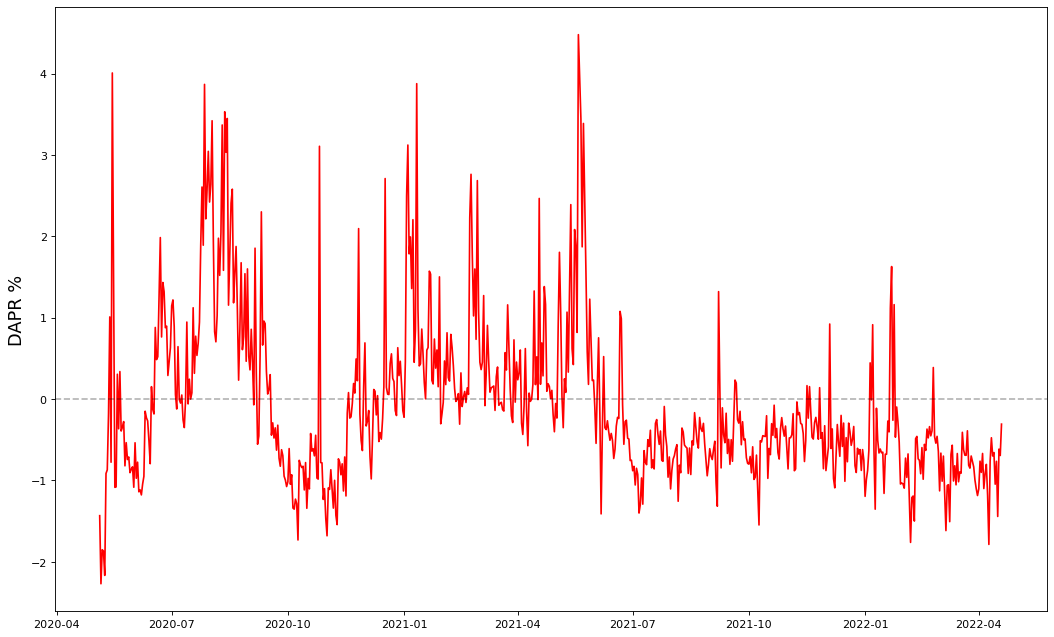

In [71]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Finding p, d, q values

In [72]:
# Find order of differencing (d)

# 1. Perform ADF test on original data
result = adfuller(DAPR_series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(DAPR_series.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(DAPR_series.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.212785
p-value: 0.000627
ADF Statistic: -9.885448
p-value: 0.000000
ADF Statistic: -11.265536
p-value: 0.000000


In [73]:
print(f'Since p-value of the original data set is less than the significance level (0.05), we do not need to difference the series')

Since p-value of the original data set is less than the significance level (0.05), we do not need to difference the series


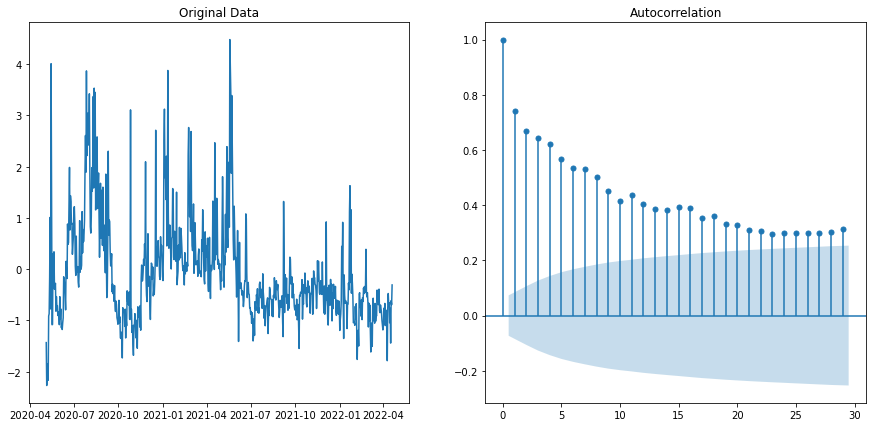

In [74]:
# 2. Graphing with ACF plot

# Original Data
f = plt.figure(figsize=(15,7))
ax1 = f.add_subplot(121)
ax1.set_title('Original Data')
ax1.plot(DAPR_series)

ax2 =  f.add_subplot(122)
plot_acf(DAPR_series.dropna(), ax=ax2)

plt.show()


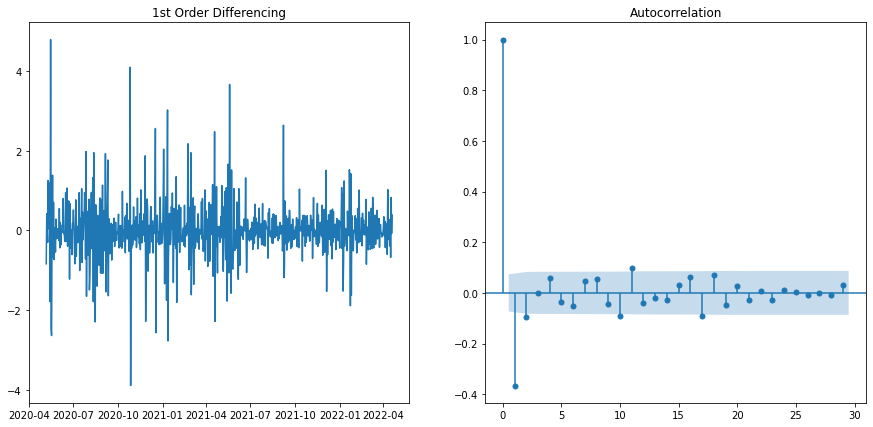

In [75]:
# 1st order differencing
f = plt.figure(figsize=(15,7))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(DAPR_series.diff())

ax2 =  f.add_subplot(122)
plot_acf(DAPR_series.diff().dropna(), ax=ax2)

plt.show()

In [76]:
print('From the graphs, we can see that data reaches stationarity with 1 order of differencing. But the lags for 1st order goes to the negative zone too quickly, indicating that the series might be over-differenced. Therefore d value is be fixed as 0.')

From the graphs, we can see that data reaches stationarity with 1 order of differencing. But the lags for 1st order goes to the negative zone too quickly, indicating that the series might be over-differenced. Therefore d value is be fixed as 0.


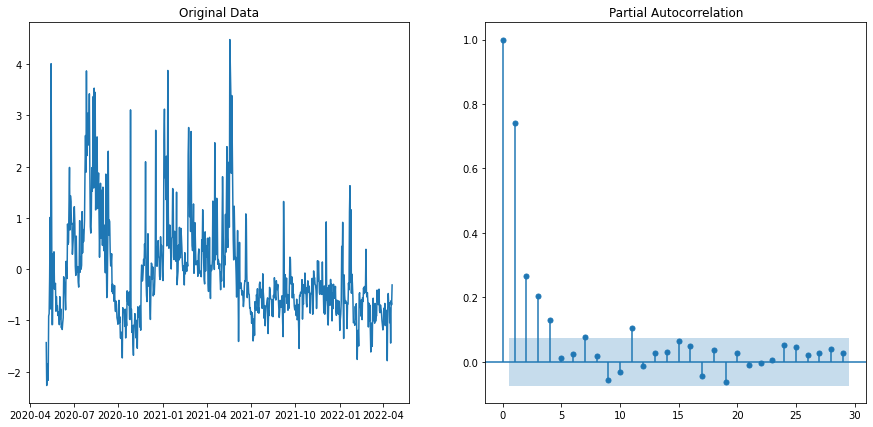

In [77]:
# Find order of AR (p)

# Graph with PACF plot

# Original Data
f = plt.figure(figsize=(15,7))
ax1 = f.add_subplot(121)
ax1.set_title('Original Data')
ax1.plot(DAPR_series)

ax2 =  f.add_subplot(122)
plot_pacf(DAPR_series.dropna(), ax=ax2)

plt.show()

In [78]:
print('From the PACF graph, we can see that up to lag 4 is significant, crossing the blue significance limit area. Therefore p value is fixed as 4.')

From the PACF graph, we can see that up to lag 4 is significant, crossing the blue significance limit area. Therefore p value is fixed as 4.


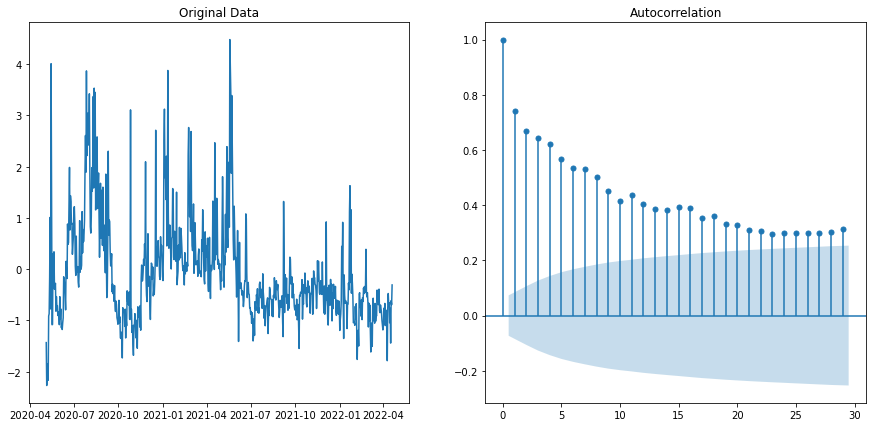

In [79]:
# Find order of MA (q)

# Original Data
f = plt.figure(figsize=(15,7))
ax1 = f.add_subplot(121)
ax1.set_title('Original Data')
ax1.plot(DAPR_series)

ax2 =  f.add_subplot(122)
plot_acf(DAPR_series.dropna(), ax=ax2)

plt.show()


In [80]:
print('All lags are above the significance limit, we can fixed q as 1.')

All lags are above the significance limit, we can fixed q as 1.


In [81]:
print('Our p, d, q values are 4, 0, 1.')

Our p, d, q values are 4, 0, 1.


## ARIMA modelling test

In [82]:
# 4,0,1 model
model = ARIMA(DAPR_series, order=(4,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  715
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -686.790
Date:                Mon, 02 May 2022   AIC                           1387.581
Time:                        01:22:43   BIC                           1419.587
Sample:                    05-05-2020   HQIC                          1399.941
                         - 04-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1202      0.258     -0.465      0.642      -0.627       0.386
ar.L1          0.7964      0.213      3.733      0.000       0.378       1.215
ar.L2         -0.0259      0.093     -0.279      0.7

<Figure size 1080x504 with 0 Axes>

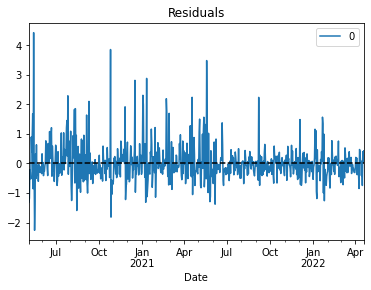

In [83]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(15,7))
residuals.plot(title="Residuals")
plt.axhline(0, linestyle='--', color='k')
plt.show()

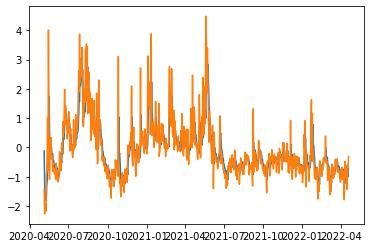

In [84]:
# Actual vs predicted values
predict = model_fit.predict(typ='levels')
plt.plot(predict)
plt.plot(DAPR_series)
plt.show()

## Automated ARIMA modelling

In [85]:
# Runs through different combinations of p,d,q for best model with lowest AIC
model = pm.auto_arima(DAPR_series, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2047.716, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1478.161, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1736.342, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1425.673, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1395.833, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1384.492, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1385.961, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1384.322, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1384.074, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1385.589, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1385.092, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1383.478, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1621.766, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1384.719, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]          

In [86]:
model = pm.auto_arima(DAPR_series, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2047.716, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1478.161, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1736.342, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1425.673, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1395.833, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1384.322, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1384.074, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1385.589, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1385.092, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1383.478, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1621.766, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1384.719, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1573.462, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1386.551, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept

In [87]:
print('We can try out ARIMA model (3,0,1)')

We can try out ARIMA model (3,0,1)


## Fitting ARIMA model with forecasting
Using Out-of-Time cross validation

In [88]:
# 1. Training and testing sets
train_end = datetime(2021,5,1) # 75% approximate
test_end = datetime(2022,4,19) # 25% 

train_data = DAPR_series[:train_end]
test_data = DAPR_series[train_end + timedelta(days=1):test_end]

In [122]:
# 2. Fit ARIMA model (3,0,1)
model = ARIMA(train_data, order=(3,0,1))  
fitted = model.fit()  

fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  362
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -403.797
Date:                Mon, 02 May 2022   AIC                            819.594
Time:                        01:38:06   BIC                            842.944
Sample:                    05-05-2020   HQIC                           828.876
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1677      0.352      0.477      0.633      -0.522       0.857
ar.L1          0.9609      0.140      6.857      0.000       0.686       1.236
ar.L2         -0.0835      0.064     -1.311      0.190      -0.208       0.041
ar.L3          0.0629      0.080      0.784      0.433      -0.094       0.220
ma.L1         -0.5436      0.146     -3.718      0.000      -0.830      -0.257
sigma2         0.5434      0.025     21.334      0.000       0.493       0.593
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               788.86
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             1.70
Prob(H) (two-sided):                  0.13   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Figure size 1080x504 with 0 Axes>

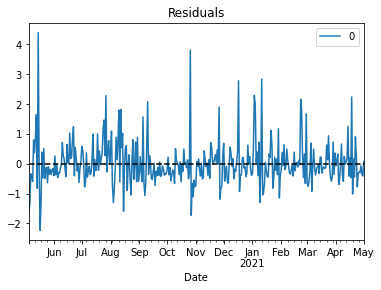

In [90]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
plt.figure(figsize=(15,7))
residuals.plot(title="Residuals")
plt.axhline(0, linestyle='--', color='k')
plt.show()

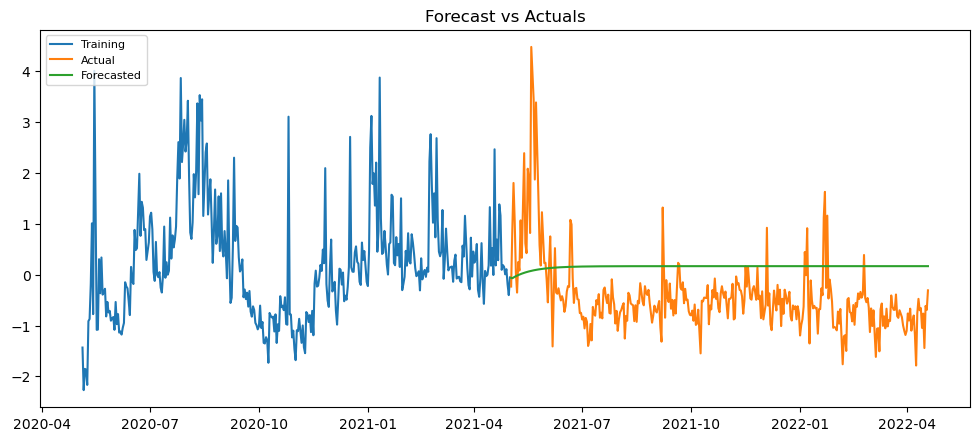

In [91]:
# Forecast
fc = fitted.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc = pd.Series(fc, index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Actual')
plt.plot(fc, label='Forecasted')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [103]:
# Accuracy Metrics
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
mae = np.mean(np.abs(fc - test_data))

print(f'MAPE = {mape}, MAE = {mae}')

MAPE = 1.32859407092683, MAE = 0.8411254064417659


In [104]:
print('Having tested out different order numbers, the 3,0,1 model had the lowest MAPE and MAE values.')

Having tested out different order numbers, the 3,0,1 model had the lowest MAPE and MAE values.


## Forecasting future values

<AxesSubplot:>

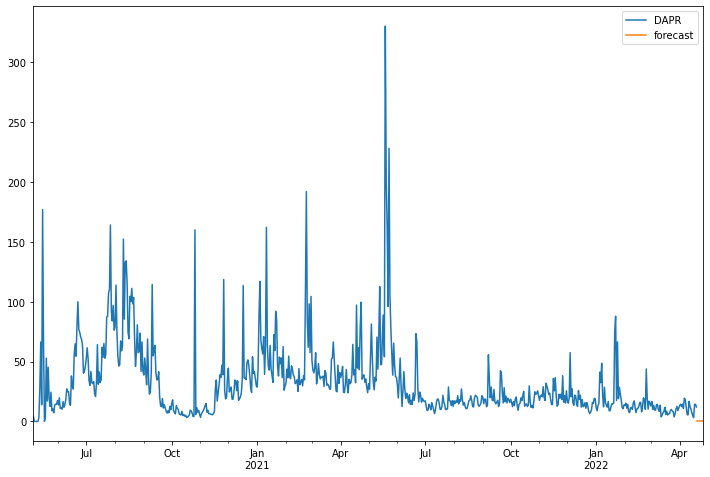

In [125]:
# Get forecast of next 7 days
future_dates=[DAPR_series.index[-1]+ DateOffset(days=x)for x in range(0,8)]
future_dates=pd.DataFrame(index=future_dates[1:],columns=data.columns)

future_dates.tail()

future_df=pd.concat([df,future_dates])

future_df['forecast'] = fitted.predict(start = 715, end = 722)
future_df[['DAPR', 'forecast']].plot(figsize=(12, 8))